## DS_Project Phase 1: Building a DataFrame with filing forms and corresponding links

In this notebook, I will go over how to access SEC filings and create a dynamic program to store the necessary information in a needed file format.   

First, I think it is important to have an idea about the structure of SEC filings and their data management practices. One way the SEC organizes the filings is categorization by company - that is, we search for a particular company and its filings. This is what I call a human-specific method of organizing the data. As a demo, let's say that a business analyst wants to do a competitive analysis on a given industry. To proceed, that person will utilize the SEC database on a company-by-company basis - individually going through filings of each company under consideration. Another way the SEC handles the data is organizing it by year/quarter/etc. A 'web page' is worth a thousand words: https://www.sec.gov/Archives/edgar/daily-index/. If you pressed the link, you can see that it takes you to a SEC webpage where you are presented with folders, starting from 1994 (when systematic data collection started) till 2020. Long story short, this method of storage is what I call computer-specific way of handling the data.        

Having basics covered, what I will do in this notebook is access SEC filings using the human-specific method. My preference for this is multifold:
1. when I research a particular company as a business analyst, I use this method
2. 'Sigma Coding' (Alex) on youtube does the same exact thing using the computer-specific method, which I find amazingly useful but confusing.    

Below is a snapshot of a table that is populated with filings of a specific company. Our job is to create a similar-looking DataFrame. It is important to note, however, that we only need columns headered 'Filings','Format' (which contains a link to the original document), and 'Filing Date'. 

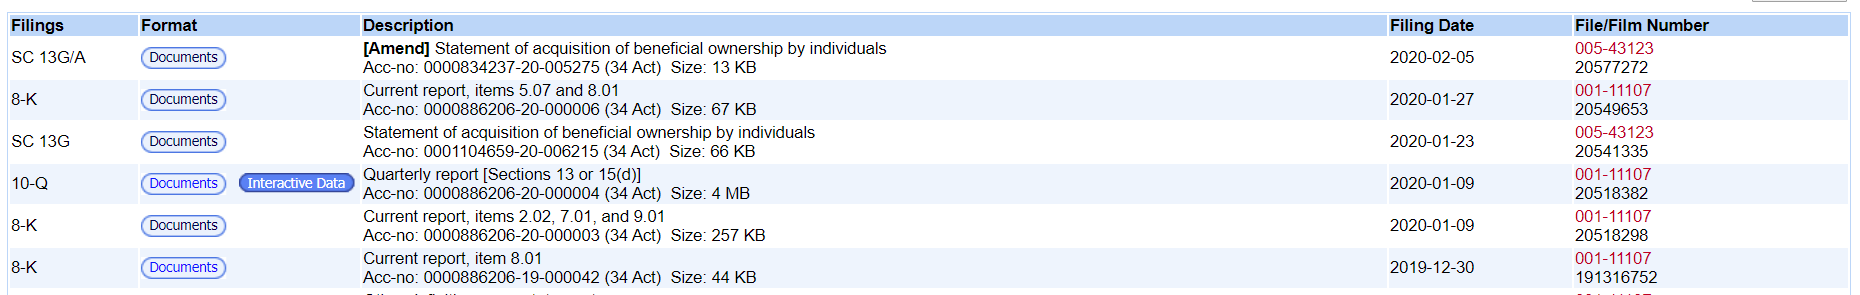

In [242]:
# import libraries
import requests
import urllib
import pandas as pd
from bs4 import BeautifulSoup
import csv
import numpy as np

# cik_number = '0000886206'
# 10k_url = f"https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK={cik_number}&type=10-k&dateb=&owner=exclude&count=100"
# 10q_url = f"https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK={cik_number}&type=10-q&dateb=&owner=exclude&count=100"

ticker = 'fc'
pages = [0, 1, 2, 3, 4, 5] 
# needs some polishing since it might cause an error when the company under consideration 
# does not have an sec webpage corresponding to one of the above numbers (most likely last ones). 

#lists that store individual items scrapped from the base_url 
filings = []
urls = []
filing_dates = []

# final list that stores individual lists and later will be turned into pd.DataFrame
final_data_list = []

# loop through each page and scrape the necessary information. 
for page in pages:
    
    base_url = f"https://www.sec.gov/cgi-bin/browse-edgar?CIK={ticker}&Find=Search&owner=exclude&start={page}00&count=100"
    response = requests.get(base_url)
    soup = BeautifulSoup(response.content, 'lxml')

    content_table = soup.find('table', class_='tableFile2')
    
    
    # a normal page in the SEC webpage is organized using various tags and their attributes.
    # The ones we need are 'tr' - row and 'td' - standard cell. 
    # print(content_table)
    for row in content_table.find_all('tr'):

        if (len(row.find_all('td')) != 0):

            # Filings section of the table
            for filing_items in row.find('td', {'nowrap':True, 'id': False, 'class': False, 'a': False}):
                filing_item = [ele.strip() for ele in row.find('td', {'nowrap': True, 'id': False, 'class': False, 'a': False})]
                filings.append(filing_item)

            # Format section of the table
            for format_items in row.find_all('a', {'id': 'documentsbutton'}):
                format_item = format_items.get('href')  #This part took forever
                sec_url = r"https://www.sec.gov"
                doc_url = format_item[1:]
                document_url = make_url(sec_url, [doc_url])
                urls.append(document_url)

            # Filing Date section of the table
            for filing_date_items in row.find('td', {'nowrap':False, 'class': False}):
                filing_date_item = [ele.strip() for ele in row.find('td', {'nowrap':False, 'class': False})]
                filing_dates.append(filing_date_item)


    # join three lists that we created at the beginning into one - 'final_data_list' - as a dictionary.
    for filing, format_1, filing_date in zip(filings, urls, filing_dates):
        final_data_list.append({'Filings': filing, 'URLs': format_1, 'Filing Date': filing_date})

# create a pandas DataFrame from the scraped data. 
df = pd.DataFrame(final_data_list)

# create a dynamic file-name and store the information.
file_name = f"sec_{ticker}" + ".csv"
df.to_csv(file_name)

# checks
df.head(5)
# df.at[99, 'URLs']


,Filings,URLs,Filing Date
0,[SC 13G/A],https://www.sec.gov/Archives/edgar/data/886206...,[2020-02-05]
1,[8-K],https://www.sec.gov/Archives/edgar/data/886206...,[2020-01-27]
2,[SC 13G],https://www.sec.gov/Archives/edgar/data/886206...,[2020-01-23]
3,[10-Q],https://www.sec.gov/Archives/edgar/data/886206...,[2020-01-09]
4,[8-K],https://www.sec.gov/Archives/edgar/data/886206...,[2020-01-09]


#### Next Things To Do
1. Go into each document
2. Make a function to access certain documents only
3. Scrape financials from 10-Ks
4. Scrape financials from 10-Qs
